<a href="https://colab.research.google.com/github/wihika/INF0619/blob/main/INF0619_Classificacao_de_revisoes_de_filmes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trabalho Final — INF-0619 Classificação de Revisões de Filmes  
Alunos:



#Descrição
O site Rotten Tomatoes é uma plataforma amplamente reconhecida que coleta e exibe avaliações de filmes feitas tanto
por usuários comuns, referidos como audiência, quanto por críticos especializados em cinema, o que proporciona
uma visão abrangente sobre a recepção de um filme. Uma tarefa crítica que surge desse conjunto de dados é a
classificação das avaliações, que pode ser realizada de diferentes maneiras, incluindo a análise do sentimento, que
identifica opiniões expressas nas críticas como positivas, negativas ou neutras, e a atribuição de notas, que facilita
a comparação entre diferentes filmes. Realizar essas análises de forma automática é de grande importância, pois
permite processar uma quantidade significativa de dados de maneira eficiente e precisa, ajudando os usuários a
fazer escolhas informadas sobre quais filmes assistir e fornecendo insights valiosos sobre tendências de recepção
cinematográfica ao longo do tempo.
A base de dados deste projeto contém avaliações de usuários, com notas variando entre 0.5 e 5, de 0.5 em 0.5, e
avaliações de críticos de cinema, com o sentimento associado (positivo ou negativo).

#Objetivo Principal
Este projeto envolve dois problemas, sendo uma tarefa binária e uma tarefa multi-classe, cujo objetivo é predizer
corretamente o sentimento da avaliação do crítico (classificação binária) e a nota de avaliação do usuário (multiclasse) baseado no texto da avaliação. A métrica que deverá ser utilizada neste projeto é a Acurácia Balanceada.

#Técnicas Envolvidas
*   Processamento de linguagem natural;
*   Processamento e representação de dados textuais;
*   Classificação binária;
*   Classificação multi-classe.

#Desafios
*   Para esse projeto, alguns desafios são:
*   Explorar técnicas de processamento de linguagem natural;
*   Analisar as palavras e termos-chaves de cada classe;
*   Lidar com o desbalanceamento de classes;
*   Classificar corretamente o sentimento das revisões dos críticos;
*   Classificar corretamente a nota da avaliação dos usuários.

#Conjunto de Dados
*   Kaggle da base de dados (https://www.kaggle.com/datasets/coltonbarger/rotten-tomatoes-reviews-for-online-streaming-shows/data);
*   Conjunto de dados (https://drive.google.com/drive/folders/10wfbJmPUqfZNs3HY4_Y_Uw1Ef0hFMRU5).


## Instalação das Bibliotecas

Instalar as bibliotecas necessárias:

In [1]:
!pip install pandas
!pip install transformers
!pip install bertviz
!pip install datasets

Chamada das bibliotecas necessárias:

In [2]:
import pandas
import numpy
import torch
import seaborn
import matplotlib.pyplot as plot
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from bertviz import model_view, head_view

## Carregar e preparar os dados

**critic_reviews**
- **Show**: titulo do show avaliado
- **Sentiment**: Sentimento sendo 0 negativo e 1 positivo (2 classes)
- **Review**: conteúdo da avaliação

In [3]:
critic_df = pandas.read_csv("train_critic.csv", header=0)
test_critic_df = pandas.read_csv("test_critic.csv", header=0)

| **Show**                           | **Review**                                                                                       | **Sentiment** |
|------------------------------------|--------------------------------------------------------------------------------------------------|---------------|
| Bodyguard                          | This has been a brilliant, compulsive, five-star drama...                                        | 1             |
| Mad Men                            | With each new season, I try to remind myself that...                                             | 0             |
| 1971: The Year That Music Changed Everything | Here's one of the most all-encompassing and stunning...                                         | 1             |
| Six Feet Under                     | To me, it was one of the most clever, funny, smart...                                            | 1             |
| Pieces of Her                      | Well acted and highly suspenseful, the eight-part drama...                                       | 0             |
| ...                                | ...                                                                                              | ...           |
| Freaks and Geeks                   | Freaks and Geeks boasts an extremely talented cast...                                            | 1             |
| The Gilded Age                     | It's a period piece set in 1882 New York that captures...                                        | 1             |
| Joe vs Carole                      | McKinnon and her co-producers must be credited for...                                            | 1             |
| Rick and Morty                     | As season openers go, this is a really solid entry...                                            | 1             |
| Y: The Last Man                    | Once the show moves past its been-there, watched-that...                                         | 1             |


**audience_reviews**
- **Show**: titulo do show avaliado
- **Rating**: nota do show de 0 a 5, com steps de 0.5 (10 classes)
- **Review**: conteúdo da avaliação

In [4]:
audience_df = pandas.read_csv("train_audience.csv", header=0)
test_audience_df = pandas.read_csv("test_audience.csv", header=0)

| **Show**                | **Review**                                                                                         | **Rating** |
|--------------------------|---------------------------------------------------------------------------------------------------|------------|
| Game of Thrones          | Lost all guidance without the book. Somehow ruined the entire legacy...                          | 0.5        |
| The Book of Boba Fett    | It felt mostly bizarre. Boba Fett himself seems out of place...                                   | 2.5        |
| Safe                     | It started well and got me hooked, but it gets dull by the end...                                 | 3.0        |
| Midnight Mass            | Here's what you get in this series: Long-winded speeches, some clever moments...                 | 2.0        |
| Star Wars: Visions       | I am a big fan of Star Wars and anime, so I really enjoyed this...                                | 4.5        |
| ...                      | ...                                                                                               | ...        |
| Ozark                    | Don't watch the last season - anticlimactic. Very disappointing...                                | 1.0        |
| Game of Thrones          | I wanted to give this higher for the excellent earlier seasons, but the ending ruins it...        | 1.5        |
| Attack on Titan          | This season will make Attack on Titan a masterpiece in storytelling and animation...              | 5.0        |
| Watchmen                 | Looks terrible. Story is about some sort of random nonsense...                                    | 0.5        |
| Peacemaker               | Fun, exciting, well-written, and enjoyable are the words that come to mind for this series...     | 5.0        |


## Variaveis de configuração


Variaveis gerais

In [5]:
IS_TEST = True  # Variavel para deixar as runs menores para testar o codigo mais rapido
MODEL_NAME = "prajjwal1/bert-tiny"  # Escolha o modelo conforme sua necessidade
NUM_EPOCHS = 35 # Número de épocas
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Define como rodar dependendo se houver GPU
MAX_LEN = 256 # Parametro usado no tokenizer

Variaveis Critic

In [6]:
NUM_LABELS_CRITIC = 2 # Número de classes para a base critic
TOKENIZER_CRITIC =  AutoTokenizer.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_CRITIC)  # Carregar o tokenizer para o critic
MODEL_CRITIC = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_CRITIC, output_attentions=False, output_hidden_states=False).to(DEVICE)  # Carregar o modelo de classificação para 2 classes

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Variaveis Audience

In [7]:
NUM_LABELS_AUDIENCE = 10 # Número de classes para a base audience
TOKENIZER_AUDIENCE =  AutoTokenizer.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_AUDIENCE)  # Carregar o tokenizer para o audience
MODEL_AUDIENCE = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_AUDIENCE, output_attentions=False, output_hidden_states=False).to(DEVICE)   # Carregar o modelo de classificação para 2 classes

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Preparação dos Conjuntos de Dados


Preparação dos dados Critic

In [8]:
critic_df = critic_df.replace([numpy.inf, -numpy.inf], numpy.nan)
critic_df.dropna(inplace=True)
test_critic_df = test_critic_df.replace([numpy.inf, -numpy.inf], numpy.nan)
test_critic_df.dropna(inplace=True)
distinct_sentiment_labels = critic_df.Sentiment.unique()
distinct_sentiment_label_dict = {}
for index, label in enumerate(distinct_sentiment_labels):
    distinct_sentiment_label_dict[label] = index

critic_df['label'] = critic_df.Sentiment.replace(distinct_sentiment_label_dict)
critic_df.label = critic_df.label.astype(int)
test_critic_df['label'] = test_critic_df.Sentiment.replace(distinct_sentiment_label_dict)
test_critic_df.label = test_critic_df.label.astype(int)

critic_df['Review'] = critic_df['Review'].astype(str)
test_critic_df['Review'] = test_critic_df['Review'].astype(str)

# balanceando os dados de treino
train_critic_class0 = critic_df[critic_df['label'] == 0]
train_critic_class1 = critic_df[critic_df['label'] == 1]
sample_size = min(len(train_critic_class0), len(train_critic_class1))
train_critic_class0_sample = train_critic_class0.sample(n=sample_size, random_state=42)
train_critic_class1_sample = train_critic_class1.sample(n=sample_size, random_state=42)
balanced_train_critic_df = pandas.concat([train_critic_class0_sample, train_critic_class1_sample], ignore_index=True)

train_critic_data, val_critic_data, train_critic_labels, val_critic_labels = train_test_split(balanced_train_critic_df.index.values,
                                                                                              balanced_train_critic_df.label.values,
                                                                                              test_size=0.2, random_state=42,
                                                                                              stratify=balanced_train_critic_df.label.values)

In [9]:
critic_df.label.value_counts()

,count
label,
0,9995
1,1836


In [10]:
 pandas.Series(train_critic_labels).value_counts()

,count
1,1469
0,1468


In [11]:
encoded_critic_data_train = TOKENIZER_CRITIC.batch_encode_plus(
    balanced_train_critic_df.loc[train_critic_data].Review.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

encoded_critic_data_val = TOKENIZER_CRITIC.batch_encode_plus(
    balanced_train_critic_df.loc[val_critic_data].Review.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

encoded_critic_data_test = TOKENIZER_CRITIC.batch_encode_plus(
    test_critic_df.Review.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

input_ids_train_critic = encoded_critic_data_train['input_ids']
input_ids_val_critic = encoded_critic_data_val['input_ids']
input_ids_test_critic = encoded_critic_data_test['input_ids']

attention_mask_train_critic = encoded_critic_data_train['attention_mask']
attention_mask_val_critic = encoded_critic_data_val['attention_mask']
attention_mask_test_critic = encoded_critic_data_test['attention_mask']

labels_train_critic = torch.tensor(balanced_train_critic_df.loc[train_critic_data].label.values)
labels_val_critic =  torch.tensor(balanced_train_critic_df.loc[val_critic_data].label.values)
labels_test_critic = torch.tensor(test_critic_df.label.values)

dataset_train_critic = TensorDataset(input_ids_train_critic, attention_mask_train_critic, labels_train_critic)
dataset_val_critic = TensorDataset(input_ids_val_critic, attention_mask_val_critic, labels_val_critic)
dataset_test_critic = TensorDataset(input_ids_test_critic, attention_mask_test_critic, labels_test_critic)

dataloader_train_critic = DataLoader(dataset_train_critic)
dataloader_val_critic = DataLoader(dataset_val_critic)
dataloader_test_critic = DataLoader(dataset_test_critic)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning

Preparação dos dados Audience

In [12]:
audience_df = audience_df.replace([numpy.inf, -numpy.inf], numpy.nan)
audience_df.dropna(inplace=True)
test_audience_df = test_audience_df.replace([numpy.inf, -numpy.inf], numpy.nan)
test_audience_df.dropna(inplace=True)
distinct_rating_labels = audience_df.Rating.unique()
distinct_rating_label_dict = {}
for index, label in enumerate(distinct_rating_labels):
    distinct_rating_label_dict[label] = index

audience_df['label'] = audience_df.Rating.replace(distinct_rating_label_dict)
audience_df.label = audience_df.label.astype(int)
test_audience_df['label'] = test_audience_df.Rating.replace(distinct_rating_label_dict)
test_audience_df.label = test_audience_df.label.astype(int)

audience_df['Review'] = audience_df['Review'].astype(str)
test_audience_df['Review'] = test_audience_df['Review'].astype(str)

# balanceando os dados de treino
train_audience_class0 = audience_df[audience_df['label'] == 0]
train_audience_class1 = audience_df[audience_df['label'] == 1]
train_audience_class2 = audience_df[audience_df['label'] == 2]
train_audience_class3 = audience_df[audience_df['label'] == 3]
train_audience_class4 = audience_df[audience_df['label'] == 4]
train_audience_class5 = audience_df[audience_df['label'] == 5]
train_audience_class6 = audience_df[audience_df['label'] == 6]
train_audience_class7 = audience_df[audience_df['label'] == 7]
train_audience_class8 = audience_df[audience_df['label'] == 8]
train_audience_class9 = audience_df[audience_df['label'] == 9]
sample_size = min(len(train_audience_class0), len(train_audience_class1), len(train_audience_class2), len(train_audience_class3), len(train_audience_class4), len(train_audience_class5), len(train_audience_class6), len(train_audience_class7), len(train_audience_class8), len(train_audience_class9))
train_audience_class0_sample = train_audience_class0.sample(n=sample_size, random_state=42)
train_audience_class1_sample = train_audience_class1.sample(n=sample_size, random_state=42)
train_audience_class2_sample = train_audience_class2.sample(n=sample_size, random_state=42)
train_audience_class3_sample = train_audience_class3.sample(n=sample_size, random_state=42)
train_audience_class4_sample = train_audience_class4.sample(n=sample_size, random_state=42)
train_audience_class5_sample = train_audience_class5.sample(n=sample_size, random_state=42)
train_audience_class6_sample = train_audience_class6.sample(n=sample_size, random_state=42)
train_audience_class7_sample = train_audience_class7.sample(n=sample_size, random_state=42)
train_audience_class8_sample = train_audience_class8.sample(n=sample_size, random_state=42)
train_audience_class9_sample = train_audience_class9.sample(n=sample_size, random_state=42)
balanced_train_audience_df = pandas.concat([train_audience_class0_sample, train_audience_class1_sample, train_audience_class2_sample, train_audience_class3_sample, train_audience_class4_sample, train_audience_class5_sample, train_audience_class6_sample, train_audience_class7_sample, train_audience_class8_sample, train_audience_class9_sample], ignore_index=True)

train_audience_data, val_audience_data, train_audience_labels, val_audience_labels = train_test_split(balanced_train_audience_df.index.values,
                                                                                                      balanced_train_audience_df.label.values,
                                                                                                      test_size=0.2, random_state=42,
                                                                                                      stratify=balanced_train_audience_df.label.values)

In [13]:
audience_df.label.value_counts()

,count
label,
5,23642
0,7016
8,3869
4,3792
7,3309
3,2690
6,2340
2,2141
9,2040


In [14]:
 pandas.Series(train_audience_labels).value_counts()

,count
8,1262
2,1262
1,1262
5,1262
0,1262
7,1262
9,1261
3,1261
4,1261
6,1261


In [15]:
encoded_audience_data_train = TOKENIZER_AUDIENCE.batch_encode_plus(
    balanced_train_audience_df.loc[train_audience_data].Review.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

encoded_audience_data_val = TOKENIZER_AUDIENCE.batch_encode_plus(
    balanced_train_audience_df.loc[val_audience_data].Review.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

encoded_audience_data_test = TOKENIZER_AUDIENCE.batch_encode_plus(
    test_audience_df.Review.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length = MAX_LEN,
    return_tensors='pt'
)

input_ids_train_audience = encoded_audience_data_train['input_ids']
input_ids_val_audience = encoded_audience_data_val['input_ids']
input_ids_test_audience = encoded_audience_data_test['input_ids']

attention_mask_train_audience = encoded_audience_data_train['attention_mask']
attention_mask_val_audience = encoded_audience_data_val['attention_mask']
attention_mask_test_audience = encoded_audience_data_test['attention_mask']

labels_train_audience = torch.tensor(balanced_train_audience_df.loc[train_audience_data].label.values)
labels_val_audience =  torch.tensor(balanced_train_audience_df.loc[val_audience_data].label.values)
labels_test_audience = torch.tensor(test_audience_df.label.values)

dataset_train_audience = TensorDataset(input_ids_train_audience, attention_mask_train_audience, labels_train_audience)
dataset_val_audience = TensorDataset(input_ids_val_audience, attention_mask_val_audience, labels_val_audience)
dataset_test_audience = TensorDataset(input_ids_test_audience, attention_mask_test_audience, labels_test_audience)

dataloader_train_audience = DataLoader(dataset_train_audience)
dataloader_val_audience = DataLoader(dataset_val_audience)
dataloader_test_audience = DataLoader(dataset_test_audience)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning

### Funções auxiliares


**Função Test** para testar o modelo, parametros são modelo e o dataloader (inputs, attention masks e labels) usados na avaliação. Retorna o loss, o array com a probabilidade de cada classe possível e os labels verdade usados.

In [16]:
def Test(model, dataloader, device):
    model.eval()

    loss_total = 0
    pred, label = [], []

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
                    'input_ids': batch[0].to(device),
                    'attention_mask': batch[1].to(device),
                    'labels': batch[2].to(device)
                  }
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_total = loss_total + loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        pred.append(logits)
        label.append(label_ids)

    average_loss = loss_total/len(dataloader)
    pred = numpy.concatenate(pred, axis=0)
    label = numpy.concatenate(label, axis=0)
    return average_loss, pred, label


**Função Treino** para treinar o modelo, parametros são modelo, nome do modelo, o dataloader de treino (inputs, attention masks e labels), o dataloader de validação, o otimizador, um scheduler (outro tipo de otimizador), numero de épocas e o device (cpu ou gpu) usados no treino. Retorna o modelo treinado.

In [17]:
def Train(model, model_name, dataloader_train, dataloader_val, optimizer, scheduler, num_epochs, device):
  train_loss_list = []
  val_loss_list = []
  train_accuracy_list = []
  val_accuracy_list = []
  train_balanced_accuracy_list = []
  val_balanced_accuracy_list = []

  for epoch in range(1, num_epochs + 1):
      model.train()

      loss_total = 0
      all_preds = []
      all_labels = []

      for batch in dataloader_train:
          model.zero_grad()

          batch = tuple(b.to(device) for b in batch)

          inputs = {
                      'input_ids': batch[0].to(device),
                      'attention_mask': batch[1].to(device),
                      'labels': batch[2].to(device)
                    }
          outputs = model(**inputs)

          loss = outputs[0]
          loss_total = loss_total + loss.item()
          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0).to(device)

          optimizer.step()
          scheduler.step()

          _, preds = torch.max(outputs[1], 1)  # Get predicted class labels
          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(batch[2].cpu().numpy())

      torch.save(model.state_dict(), f'finetuned_{model_name}_{epoch}.model')
      print(f'Epoca {epoch}')

      loss_avg_train = loss_total/len(dataloader_train)
      train_loss_list.append(loss_avg_train)
      print(f'Traning Loss: {loss_avg_train}')
      val_loss, preds, labels = Test(model, dataloader_val, device)
      val_loss_list.append(val_loss)
      print(f'Validation Loss: {val_loss}')

      train_accuracy = accuracy_score(all_labels, all_preds)
      train_accuracy_list.append(train_accuracy)
      print(f'Train Accuracy: {train_accuracy}')
      preds_array = numpy.argmax(preds, axis=1)
      val_accuracy = accuracy_score(labels, preds_array)
      val_accuracy_list.append(val_accuracy)
      print(f'Validation Accuracy: {val_accuracy}')

      train_balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
      train_balanced_accuracy_list.append(train_balanced_accuracy)
      print(f'Train Balanced Accuracy: {train_balanced_accuracy}')
      val_balanced_accuracy = balanced_accuracy_score(labels, preds_array)
      val_balanced_accuracy_list.append(val_balanced_accuracy)
      print(f'Validation Balanced Accuracy: {val_balanced_accuracy}')

  data = {'train_loss': train_loss_list, 'val_loss': val_loss_list, 'train_accuracy': train_accuracy_list, 'val_accuracy': val_accuracy_list, 'train_balanced_accuracy': train_balanced_accuracy_list, 'val_balanced_accuracy': val_balanced_accuracy_list}
  df = pandas.DataFrame(data)

  return model, df

**Função de Plot da Matriz de Confusão** para analisar o modelo, parametros labels verdade, classes preditas, titulo e lista de possiveis classes. Plota a matriz.

In [18]:
def ConfusionMatrix(labels, preds_array, title, classes_list):
  cm = confusion_matrix(labels, preds_array)
  cm_normalized = cm.astype('float') / len(labels)

  plot.figure(figsize=(8, 6))
  seaborn.heatmap(cm_normalized, annot=True, fmt=".0%", cmap="Blues",
              xticklabels=classes_list, yticklabels=classes_list)
  plot.xlabel("Predicted Labels")
  plot.ylabel("True Labels")
  plot.title(title)
  plot.show()

### Treino Modelo

Modelo Critic

In [19]:
optimizer_critic = AdamW(MODEL_CRITIC.parameters(),
                  lr=1e-5)

num_training_steps = len(dataloader_train_critic) * NUM_EPOCHS

num_warmup_steps = int(0.1 * num_training_steps)

scheduler_critic = get_scheduler(
    "linear",
    optimizer=optimizer_critic,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

MODEL_CRITIC, model_critic_train_results = Train(MODEL_CRITIC, 'CRITIC', dataloader_train_critic, dataloader_val_critic, optimizer_critic, scheduler_critic, NUM_EPOCHS, DEVICE)

Epoca 1
Traning Loss: 0.7042456899405256
Validation Loss: 0.6991569519853916
Train Accuracy: 0.49982975825672454
Validation Accuracy: 0.5006802721088436
Train Balanced Accuracy: 0.4999988407098195
Validation Balanced Accuracy: 0.5
Epoca 2
Traning Loss: 0.6956433136425824
Validation Loss: 0.6837732218560718
Train Accuracy: 0.5042560435818862
Validation Accuracy: 0.5510204081632653
Train Balanced Accuracy: 0.5044187504521231
Validation Balanced Accuracy: 0.5506456580973819
Epoca 3
Traning Loss: 0.6758997279809452
Validation Loss: 0.6692155496603778
Train Accuracy: 0.5635001702417433
Validation Accuracy: 0.5782312925170068
Train Balanced Accuracy: 0.5636019053165975
Validation Balanced Accuracy: 0.5785970264186707
Epoca 4
Traning Loss: 0.6797012942438837
Validation Loss: 1.1516332182754465
Train Accuracy: 0.6418113721484509
Validation Accuracy: 0.5755102040816327
Train Balanced Accuracy: 0.6418008970123701
Validation Balanced Accuracy: 0.5759758914820519
Epoca 5
Traning Loss: 0.9750007823

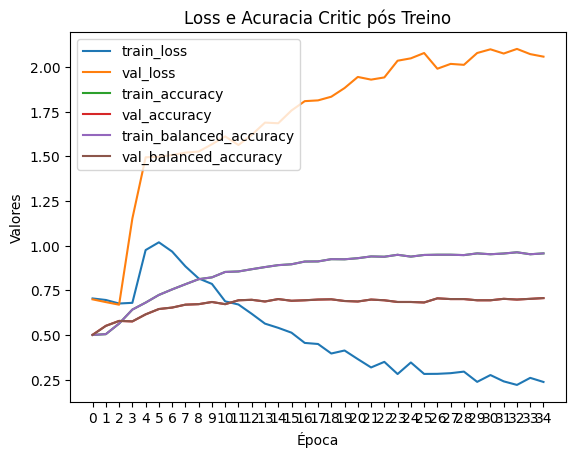

In [20]:
model_critic_train_results.plot(kind='line')
plot.title('Loss e Acuracia Critic pós Treino')
plot.xticks(range(0, len(model_critic_train_results), 1))
plot.xlabel('Época')
plot.ylabel('Valores')
plot.legend(loc='best')
plot.show()

Modelo Audience

In [ ]:
optimizer_audience = AdamW(MODEL_AUDIENCE.parameters(),
                  lr=1e-5)

num_training_steps = len(dataloader_train_audience) * NUM_EPOCHS

num_warmup_steps = int(0.1 * num_training_steps)

scheduler_audience = get_scheduler(
    "linear",
    optimizer=optimizer_audience,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

MODEL_AUDIENCE, model_audience_train_results = Train(MODEL_AUDIENCE, 'AUDIENCE', dataloader_train_audience, dataloader_val_audience, optimizer_audience, scheduler_audience, NUM_EPOCHS, DEVICE)

Epoca 1
Traning Loss: 2.3108202627303105
Validation Loss: 2.2993700772656167
Train Accuracy: 0.10962270133164236
Validation Accuracy: 0.13157894736842105
Train Balanced Accuracy: 0.10960448214193699
Validation Balanced Accuracy: 0.13165461121157324
Epoca 2
Traning Loss: 2.285793256914608
Validation Loss: 2.2489485028202805
Train Accuracy: 0.13577996195307546
Validation Accuracy: 0.16677235256816741
Train Balanced Accuracy: 0.1357775820010532
Validation Balanced Accuracy: 0.16670986538075144
Epoca 3
Traning Loss: 2.15163631268559
Validation Loss: 2.0344189471206713
Train Accuracy: 0.1945149017121116
Validation Accuracy: 0.2206721623335447
Train Balanced Accuracy: 0.19451099735952776
Validation Balanced Accuracy: 0.22076451677717496
Epoca 4
Traning Loss: 1.987934013853439
Validation Loss: 1.9360103307642662
Train Accuracy: 0.2310558021559924
Validation Accuracy: 0.2568167406467977
Train Balanced Accuracy: 0.2310542032019967
Validation Balanced Accuracy: 0.25679123970263207
Epoca 5
Tranin

In [ ]:
model_audience_train_results.plot(kind='line')
plot.title('Loss e Acuracia Audience pós Treino')
plot.xticks(range(0, len(model_audience_train_results), 1))
plot.xlabel('Época')
plot.ylabel('Valores')
plot.legend(loc='best')
plot.show()

### Avaliação do Modelo no Conjunto Test

Modelo Critic

In [ ]:
best_epoch_critic = 1
model_config_critic = f'finetuned_CRITIC_{best_epoch_critic}.model'
best_model_critic = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_CRITIC, output_attentions=True, output_hidden_states=False)
best_model_critic.load_state_dict(torch.load(model_config_critic, map_location=torch.device('cpu')))
best_model_critic.to(DEVICE)

print("Melhor modelo")
_, preds, labels = Test(best_model_critic, dataloader_test_critic, DEVICE)
print(f'Test Loss: {_}')
preds_array = numpy.argmax(preds, axis=1)
val_accuracy_2 = accuracy_score(labels, preds_array)
print(f'Test Accuracy: {val_accuracy_2}')
val_balanced_accuracy_2 = balanced_accuracy_score(labels, preds_array)
print(f'Test Balanced Accuracy: {val_balanced_accuracy_2}')

ConfusionMatrix(labels, preds_array, title="Matrix de confusão - Modelo Critic", classes_list=distinct_sentiment_labels)

Modelo Audience

In [ ]:
best_epoch_audience = 1
model_config_audience = f'finetuned_AUDIENCE_{best_epoch_audience}.model'
best_model_audience = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS_AUDIENCE, output_attentions=True, output_hidden_states=False)
best_model_audience.load_state_dict(torch.load(model_config_audience, map_location=torch.device('cpu')))
best_model_audience.to(DEVICE)

print("Melhor modelo")
_, preds, labels = Test(best_model_audience, dataloader_test_audience, DEVICE)
print(f'Test Loss: {_}')
preds_array = numpy.argmax(preds, axis=1)
val_accuracy_2 = accuracy_score(labels, preds_array)
print(f'Test Accuracy: {val_accuracy_2}')
val_balanced_accuracy_2 = balanced_accuracy_score(labels, preds_array)
print(f'Test Balanced Accuracy: {val_balanced_accuracy_2}')

ConfusionMatrix(labels, preds_array, title="Matrix de confusão - Modelo Audience", classes_list=distinct_rating_labels)

### Análise do Mecanismo de Atenção com BertViz



Modelo Critic

In [ ]:
input_ids=[]
for batch in dataloader_test_critic:
    input_ids.append(batch[0])

print(f'Modelo Critic')
correct_cases_critic = [(text, true, pred) for text, true, pred in zip(input_ids, labels_test_critic, preds_array) if true == pred]
print(f'Número de acertos: {len(correct_cases_critic)}')

decoded_correct_text_critic = TOKENIZER_CRITIC.decode(torch.tensor(correct_cases_critic[0][0][0].tolist()), skip_special_tokens=True)
print(f'Texto caso correto: {decoded_correct_text_critic}')

incorrect_cases_critic =[(text, true, pred) for text, true, pred in zip(input_ids, labels_test_critic, preds_array) if true != pred]
print(f'Número de incorretos: {len(incorrect_cases_critic)}')

decoded_incorrect_text_critic = TOKENIZER_CRITIC.decode(torch.tensor(incorrect_cases_critic[0][0][0].tolist()), skip_special_tokens=True)
print(f'Texto caso incorreto: {decoded_incorrect_text_critic}')

In [ ]:
model = best_model_critic
print("Análise para um comentário que foi corretamente predito")
inputs = TOKENIZER_CRITIC.encode(decoded_correct_text_critic, return_tensors='pt').to(DEVICE)
outputs = model(inputs)
attention = outputs[-1]
tokens = TOKENIZER_CRITIC.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)
model_view(attention, tokens)

print("Análise para um comentário que foi incorretamente predito")
inputs = TOKENIZER_CRITIC.encode(decoded_incorrect_text_critic, return_tensors='pt').to(DEVICE)
outputs = model(inputs)
attention = outputs[-1]
tokens = TOKENIZER_CRITIC.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)
model_view(attention, tokens)

Modelo Audience

In [ ]:
input_ids=[]
for batch in dataloader_test_audience:
    input_ids.append(batch[0])

print(f'Modelo Audience')
correct_cases_audience = [(text, true, pred) for text, true, pred in zip(input_ids, labels_test_audience, preds_array) if true == pred]
print(f'Número de acertos: {len(correct_cases_audience)}')

decoded_correct_text_audience = TOKENIZER_AUDIENCE.decode(torch.tensor(correct_cases_audience[0][0][0].tolist()), skip_special_tokens=True)
print(f'Texto caso correto: {decoded_correct_text_audience}')

incorrect_cases_audience =[(text, true, pred) for text, true, pred in zip(input_ids, labels_test_audience, preds_array) if true != pred]
print(f'Número de incorretos: {len(incorrect_cases_audience)}')

decoded_incorrect_text_audience = TOKENIZER_AUDIENCE.decode(torch.tensor(incorrect_cases_audience[0][0][0].tolist()), skip_special_tokens=True)
print(f'Texto caso incorreto: {decoded_incorrect_text_audience}')

In [ ]:
model = best_model_audience
print("Análise para um comentário que foi corretamente predito")
inputs = TOKENIZER_AUDIENCE.encode(decoded_correct_text_audience, return_tensors='pt').to(DEVICE)
outputs = model(inputs)
attention = outputs[-1]
tokens = TOKENIZER_AUDIENCE.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)
model_view(attention, tokens)

print("Análise para um comentário que foi incorretamente predito")
inputs = TOKENIZER_AUDIENCE.encode(decoded_incorrect_text_audience, return_tensors='pt').to(DEVICE)
outputs = model(inputs)
attention = outputs[-1]
tokens = TOKENIZER_AUDIENCE.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)
model_view(attention, tokens)